# Preparation

In [ ]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
from sklearn.impute import SimpleImputer

# Load data
file_path = 'Processed_Data.xlsx'
macros = pd.read_excel(file_path, sheet_name='HP_Filtered_macro')
prices = pd.read_excel(file_path, sheet_name='Portfolio')


In [ ]:
# # Prepare macroeconomic data
# macros.set_index('Date', inplace=True)
# prices.set_index('Date', inplace=True)

# # Handle missing values
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(macros)
# Y_imputed = imputer.fit_transform(prices)

# # Convert to JAX array
# X = jnp.array(X_imputed)
# Y = jnp.array(Y_imputed)

## Correlation Matrix Between Macro Variables

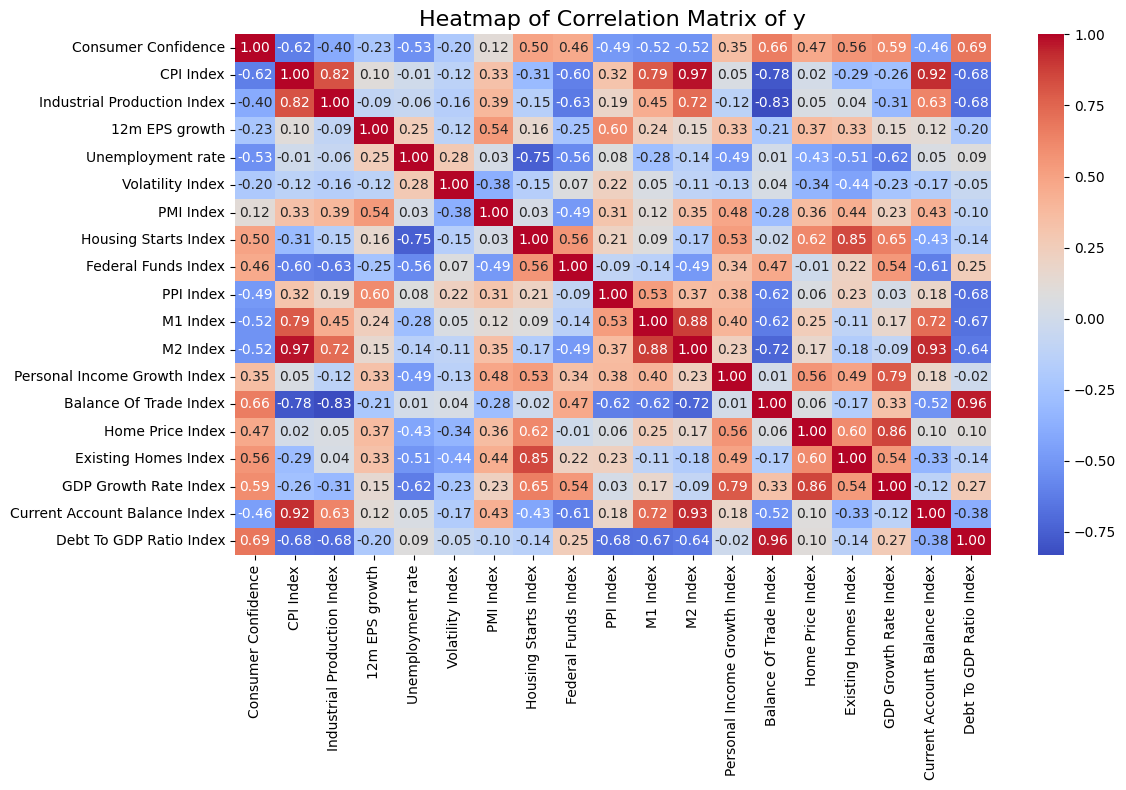

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


y = macros.set_index('Date', inplace=True)
correlation_matrix_y = y.corr()

# Draw the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_y, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Heatmap of Correlation Matrix of y", fontsize=16)
plt.tight_layout()
plt.show()


## Model I: Ridge Reression

In [ ]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Model definitions
@jit
def model(X, w, b):
    return jnp.dot(X, w) + b

@jit
def loss_fn(w, b, X, y):
    predictions = model(X, w, b)
    return jnp.mean((predictions - y) ** 2)

@jit
def loss_fn_ridge(w, b, X, y, lambda_ridge):
    predictions = model(X, w, b)
    mse = jnp.mean((predictions - y) ** 2)
    ridge_penalty = lambda_ridge * jnp.sum(w ** 2)
    return mse + ridge_penalty


### (1)Training
Use normal and Ridge model

In [ ]:
# Gradient calculations with JIT compilation
grad_loss_linear = jit(grad(loss_fn, argnums=(0, 1)))
grad_loss_ridge = jit(grad(loss_fn_ridge, argnums=(0, 1)))

# Hyperparameters
learning_rate = 0.01
num_epochs = 1000
lambda_ridge = 0.1

# Normalize features
scaler_X = StandardScaler()

# Results storage
results = []

# Iterate over portfolios
for portfolio_name in prices.columns[1:]:
    print(f"Processing Portfolio: {portfolio_name}")
    aligned_data = pd.merge(macros, prices[['Date', portfolio_name]], on='Date', how='inner').dropna()
    X = aligned_data[macros.columns.difference(['Date'])]
    # Separate features and target
    X_normalized = scaler_X.fit_transform(X)
    y = aligned_data[portfolio_name]
    # Normalize target
    scaler_y = StandardScaler()
    y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

    X_train, X_test = jnp.array(X_train), jnp.array(X_test)
    y_train, y_test = jnp.array(y_train), jnp.array(y_test)

    # Linear Regression
    key = random.PRNGKey(0)
    w_linear = random.normal(key, (X_train.shape[1],))
    b_linear = 0.0

    for epoch in range(num_epochs):
        grad_w, grad_b = grad_loss_linear(w_linear, b_linear, X_train, y_train)
        w_linear -= learning_rate * grad_w
        b_linear -= learning_rate * grad_b

    mse_linear_train = loss_fn(w_linear, b_linear, X_train, y_train)
    mse_linear_test = loss_fn(w_linear, b_linear, X_test, y_test)

    # Ridge Regression
    w_ridge = random.normal(key, (X_train.shape[1],))
    b_ridge = 0.0

    for epoch in range(num_epochs):
        grad_w_ridge, grad_b_ridge = grad_loss_ridge(w_ridge, b_ridge, X_train, y_train, lambda_ridge)
        w_ridge -= learning_rate * grad_w_ridge
        b_ridge -= learning_rate * grad_b_ridge

    mse_ridge_train = loss_fn_ridge(w_ridge, b_ridge, X_train, y_train, lambda_ridge)
    mse_ridge_test = loss_fn_ridge(w_ridge, b_ridge, X_test, y_test, lambda_ridge)

    # Save results
    results.append({
        'Portfolio': portfolio_name,
        'Linear Regression MSE (Train)': float(mse_linear_train),
        'Linear Regression MSE (Test)': float(mse_linear_test),
        'Linear Model (w, b)': (w_linear.tolist(), float(b_linear)),
        'Ridge Regression MSE (Train)': float(mse_ridge_train),
        'Ridge Regression MSE (Test)': float(mse_ridge_test),
        'Ridge Model (w, b)': (w_ridge.tolist(), float(b_ridge))
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to Excel and display
results_df.to_excel('Portfolio_Model_Performance_Normalized_Optimized.xlsx', index=False)


Processing Portfolio: SP500 ETF
Processing Portfolio: Corp bonds
Processing Portfolio: USD/EUR
Processing Portfolio: REIT
Processing Portfolio: Gold price (USD)


#### (2)Comparison

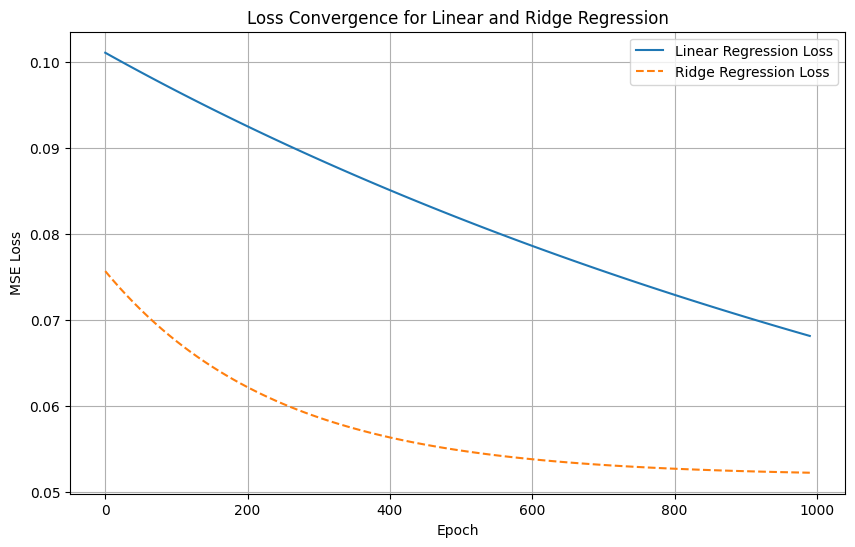

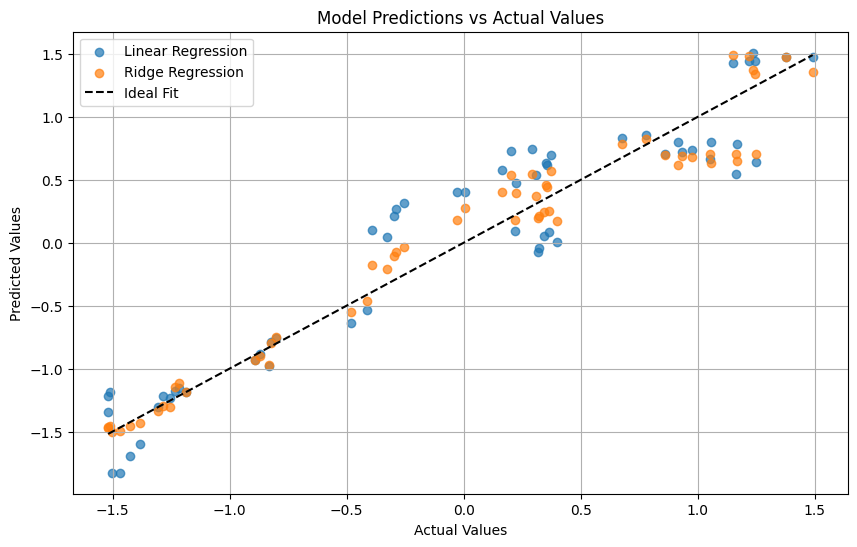

In [ ]:
import matplotlib.pyplot as plt

# Placeholder for loss tracking
loss_linear = []
loss_ridge = []

# Simulate the training process to capture loss at each epoch
for epoch in range(num_epochs):
    grad_w, grad_b = grad_loss_linear(w_linear, b_linear, X_train, y_train)
    w_linear -= learning_rate * grad_w
    b_linear -= learning_rate * grad_b
    if epoch % 10 == 0:
        loss_linear.append(float(loss_fn(w_linear, b_linear, X_train, y_train)))

    grad_w_ridge, grad_b_ridge = grad_loss_ridge(w_ridge, b_ridge, X_train, y_train, lambda_ridge)
    w_ridge -= learning_rate * grad_w_ridge
    b_ridge -= learning_rate * grad_b_ridge
    if epoch % 10 == 0:
        loss_ridge.append(float(loss_fn_ridge(w_ridge, b_ridge, X_train, y_train, lambda_ridge)))

# Plot Loss Convergence
plt.figure(figsize=(10, 6))
plt.plot(range(0, num_epochs, 10), loss_linear, label="Linear Regression Loss")
plt.plot(range(0, num_epochs, 10), loss_ridge, label="Ridge Regression Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Convergence for Linear and Ridge Regression")
plt.legend()
plt.grid()
plt.show()

# Predictions for comparison
y_pred_linear = model(X_test, w_linear, b_linear)
y_pred_ridge = model(X_test, w_ridge, b_ridge)

# Plot Model Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, label="Linear Regression", alpha=0.7)
plt.scatter(y_test, y_pred_ridge, label="Ridge Regression", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Model Predictions vs Actual Values")
plt.legend()
plt.grid()
plt.show()


## Model II:Identify Extreme Condition

#### (1)Weights Transfer

$w1$ is weight vector of 5 assets. $y$ is return vector\
$w2$ is vector of 5 * 13 (assets * macro variables), which we got from the above LASSO regression model between asset prices and macro vars. $x$ is a vector of 13 macro values.

We will begin with a range of W1, define a loss level L:\
$L=∑_{i}(w1_i * y_i)$.

We have $y_i = \sum_{j} w2_{ij}*x_{ij}$, \
so introduce $w2$ into $L$, exchange the sum sequence, get
$L = \sum_{j} w2_j * x_j$, j=0,1,2,...13.




In [ ]:
asset_weights = np.array([0.6, 0.4, -0.35, 0.5, -0.15])
lasso_weights = np.vstack(results_df['Ridge Model (w, b)'].apply(lambda x: x[0]))
macro_weights = lasso_weights.T @ asset_weights
macro_weights

array([ 0.09808447, -0.13155423,  0.10455285,  0.13848622,  0.48142643,
       -0.21240971, -0.09192798, -0.05691486,  0.06367645, -0.03974595,
       -0.07830753,  0.41432511,  0.02611584,  0.11708048,  0.12416409,
        0.02779816, -0.0085647 , -0.13950941,  0.18541794])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


scaler_X = StandardScaler()
X_normalized = scaler_X.fit_transform(X)
Y_normalized = scaler_y.fit_transform(Y)

cov_matrix = np.cov(X_normalized, rowvar=False)  # Set rowvar=False to treat columns as variables
cov_matrix_df = pd.DataFrame(cov_matrix, index=macros.columns[1:], columns=macros.columns[1:])
cov_matrix_df

,Consumer Confidence,CPI Index,Industrial Production Index,12m EPS growth,Unemployment rate,Volatility Index,PMI Index,Housing Starts Index,Federal Funds Index,PPI Index,M1 Index,M2 Index,Personal Income Growth Index,Balance Of Trade Index,Home Price Index,Existing Homes Index,GDP Growth Rate Index,Current Account Balance Index,Debt To GDP Ratio Index
Consumer Confidence,1.003497,-0.328441,0.106193,-0.192972,0.107616,-0.249748,0.331938,-0.315627,0.277950,0.368761,0.205956,-0.123249,0.237597,0.156235,0.607577,0.614492,0.417528,0.218206,-0.012635
CPI Index,-0.328441,1.003497,-0.603658,0.524833,-0.367988,0.958661,-0.160426,-0.228526,-0.237719,0.065093,-0.280619,-0.545483,-0.731135,-0.614346,-0.205376,-0.710027,-0.522477,0.302530,0.088804
Industrial Production Index,0.106193,-0.603658,1.003497,-0.457261,0.948343,-0.455810,-0.327927,-0.280657,0.169542,0.015768,-0.248455,0.798813,0.839595,0.979960,0.271440,0.209723,0.409032,-0.192089,-0.169532
12m EPS growth,-0.192972,0.524833,-0.457261,1.003497,-0.323089,0.568333,0.629797,0.142962,0.385983,0.470879,0.467168,-0.080463,-0.481732,-0.362620,0.242691,-0.426477,0.179348,-0.482366,-0.410749
Unemployment rate,0.107616,-0.367988,0.948343,-0.323089,1.003497,-0.176999,-0.360948,-0.506634,0.175863,0.097202,-0.384551,0.742667,0.706746,0.928068,0.399719,0.089208,0.406196,-0.051806,-0.174458
Volatility Index,-0.249748,0.958661,-0.455810,0.568333,-0.176999,1.003497,-0.124827,-0.426065,-0.187241,0.100366,-0.358434,-0.350601,-0.703764,-0.479832,0.054423,-0.708973,-0.397797,0.319242,-0.079819
PMI Index,0.331938,-0.160426,-0.327927,0.629797,-0.360948,-0.124827,1.003497,0.270769,0.623690,0.606584,0.869721,0.014908,-0.115438,-0.200781,0.437567,0.222937,0.517261,-0.538057,-0.441207
Housing Starts Index,-0.315627,-0.228526,-0.280657,0.142962,-0.506634,-0.426065,0.270769,1.003497,0.221154,-0.014150,0.616948,-0.144092,0.065147,-0.218491,-0.520416,0.138908,0.095343,-0.599271,0.078042
Federal Funds Index,0.277950,-0.237719,0.169542,0.385983,0.175863,-0.187241,0.623690,0.221154,1.003497,0.861210,0.676242,0.315656,0.411589,0.307124,0.419819,0.256289,0.764437,-0.611360,-0.457584
PPI Index,0.368761,0.065093,0.015768,0.470879,0.097202,0.100366,0.606584,-0.014150,0.861210,1.003497,0.622763,0.050689,0.255110,0.168098,0.357818,0.056885,0.562522,-0.430445,-0.339876


### (1)Parameter Selection: M, Scenarios, and q, Relative Likelihood

M by PCA, q is intentionally decided.
But PCA only works when variance matrix distributed without extreme values.


In [ ]:
from sklearn.decomposition import PCA


# Perform PCA
pca = PCA()
pca.fit(cov_matrix)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find number of components to explain 90% variance
M = np.argmax(cumulative_variance >= 0.9)
print("Number of components (M):", M)


Number of components (M): 2


### (2)Identify Extreme Scenarios

By this step, we find out under some values of macro variables(we call scenarios) would cause our certain portfolios suffer from a given loss.

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform  # 导入 pdist 和 squareform


def filter_and_normalize_weights(weights, epsilon):
    J = [j for j, w in enumerate(weights) if abs(w) > epsilon]
    v = np.sqrt(len(J)) * np.array(weights)[J] / np.linalg.norm(np.array(weights)[J])
    return J, v


def reduce_covariance_matrix(cov_matrix, J, v):
    D_J = cov_matrix[np.ix_(J, J)]  # Submatrix for indices in J
    V = np.diag(v)
    return V @ D_J @ V.T  # Scaled covariance matrix


def compute_conditional_mean_and_covariance(w_reduced, D_reduced, L):
    d11 = w_reduced.T @ D_reduced @ w_reduced
    mean_cond = (L / d11) * (D_reduced @ w_reduced)
    D_cond = D_reduced - (np.outer(D_reduced @ w_reduced, D_reduced @ w_reduced) / d11)

    # Regularize covariance matrix to ensure positive definiteness
    D_cond += np.eye(D_cond.shape[0]) * 1e-1 # Add small value to diagonal
    return mean_cond, D_cond


def generate_random_points(M, dim):
    """Generate M+1 random points in the given dimensional space."""
    points = np.eye(dim) - np.ones((dim, dim)) / dim  # Construct simplex vertices
    centroid = np.mean(points, axis=0)  # Calculate centroid
    points -= centroid  # Center the simplex at the origin
    points /= np.linalg.norm(points, axis=1, keepdims=True)  # Normalize to unit length
    return points[:M]


def scale_and_shift_points(simplex_points, mean_cond, D_cond, q):
    scenarios = []
    for z in simplex_points:
        quad_form = z.T @ np.linalg.inv(D_cond) @ z
        r = np.sqrt(np.log(1 / q) / (quad_form + 1e-6))  # Stabilize quad_form
        noise = np.random.normal(scale=1e-1, size=z.shape)  # Add small noise
        y = r * z + mean_cond + noise
        scenarios.append(y)
    return np.array(scenarios)


def back_transform_to_original(scenarios_reduced, v, J, n):
    X = np.zeros((len(scenarios_reduced), n))
    for i, x in enumerate(scenarios_reduced):
        X[i, J] = x / v  # Scale and assign reduced values to original indices
    return X


def project_to_hyperplane(point, w, L):
    adjustment = (L - np.dot(w, point)) / np.dot(w, w)
    return point + adjustment * w


def reverse_stress_test(w, D, L, M, q, epsilon=0.01):
    J, v = filter_and_normalize_weights(w, epsilon)
    D_reduced = reduce_covariance_matrix(D, J, v)
    w_reduced = np.array(w)[J]
    mean_cond, D_cond = compute_conditional_mean_and_covariance(w_reduced, D_reduced, L)

    print("Mean conditional:", mean_cond)
    print("Reduced covariance matrix:", D_cond)

    reduced_dim = len(J)
    simplex_points = generate_random_points(M, reduced_dim)
    scenarios_reduced = scale_and_shift_points(simplex_points, mean_cond, D_cond, q)

    distances = pdist(scenarios_reduced)
    print("Pairwise distances among reduced scenarios:", distances)

    scenarios_original = back_transform_to_original(scenarios_reduced, v, J, len(w))
    scenarios_original = np.array([project_to_hyperplane(scenario, w, L) for scenario in scenarios_original])

    for scenario in scenarios_original:
        assert abs(np.dot(w, scenario) - L) < 1e-5, "Scenario does not satisfy hyperplane constraint."

    return scenarios_original


# Example Usage
if __name__ == "__main__":
    w = np.array([0.2, 0.1, 0.4, 0.3])  # Portfolio weights
    D = np.array([[0.1, 0.02, 0.01, 0.03],
                  [0.02, 0.08, 0.04, 0.01],
                  [0.01, 0.04, 0.09, 0.02],
                  [0.03, 0.01, 0.02, 0.07]])  # Covariance matrix
    L = 0.05  # Loss level
    M = 5  # Number of additional scenarios
    q = 0.1  # Relative likelihood threshold

    scenarios = reverse_stress_test(w, D, L, M, q)
    print("Generated Scenarios:\n", scenarios)


Mean conditional: [0.02062606 0.01079835 0.08250425 0.03931085]
Reduced covariance matrix: [[ 0.14398285  0.00043808 -0.02673526  0.00617908]
 [ 0.00043808  0.10810386  0.00175233 -0.00532977]
 [-0.02673526  0.00175233  0.1423923  -0.03928367]
 [ 0.00617908 -0.00532977 -0.03928367  0.15003543]]
Pairwise distances among reduced scenarios: [1.20622742 1.08985653 0.94683098 0.80082213 0.8619334  0.86138694]
Generated Scenarios:
 [[ 0.8505726  -0.69378971 -0.13493436  0.01079398]
 [-0.49101695  1.03974561  0.08855344  0.02935817]
 [-0.1429491  -0.14923336  0.30824621 -0.09928442]
 [-0.12592498 -0.27316913 -0.09731111  0.47142118]]


In [ ]:
num_scenarios = 5  # Number of scenarios to generate
relative_likelihood = 0.1  # Relative likelihood threshold
loss_level = 0.2  # Portfolio loss level

# begin with time 0
initial_asset = asset_weights @ Y_normalized[0]
if initial_asset<0:
  L = initial_asset * (loss_level + 1)
else:
  L = initial_asset * (1-loss_level)

# Perform reverse stress testing
scenarios = reverse_stress_test(macro_weights, cov_matrix, L, num_scenarios, relative_likelihood)

# Output the scenarios
print("Generated Scenarios (Original Space):")
print(scenarios)

Mean conditional: [-2.22605528e-02 -2.57379371e-01 -5.39697544e-01  1.20100164e-01
 -2.66203216e+00 -1.45869688e-01 -1.15554594e-01 -1.57147968e-01
 -9.20823297e-02  3.17433865e-02 -1.36804255e-01 -2.00509807e+00
 -9.13412659e-02 -5.89241161e-01 -3.50771888e-01 -2.44206325e-04
 -1.32602648e-01  3.87525373e-01]
Reduced covariance matrix: [[ 3.82817531e-01  1.19155596e-01  2.10629705e-02 -7.44863132e-02
   9.53895005e-02  1.49727370e-01 -9.01497161e-02  4.85278326e-02
   4.90780630e-02 -4.15405293e-02 -4.91752193e-02 -1.87420320e-01
   1.60146074e-02  4.07535740e-02  2.10030764e-01  4.91550408e-02
  -9.02848719e-02  1.07726956e-03]
 [ 1.19155596e-01  5.49524893e-01  1.17708366e-01 -2.52531931e-01
   6.27826194e-02  7.51970842e-01 -8.38839963e-02 -8.68671134e-02
   3.69460257e-02  1.73921924e-02 -1.16737304e-01  4.04596629e-01
   5.23932816e-02  1.40170803e-01  1.65960068e-02  7.61289494e-02
   1.31977097e-01  2.68515525e-02]
 [ 2.10629705e-02  1.17708366e-01  1.57838908e-01 -1.35507890e-

## Applications

### (1)Enhancing risk decomposition

Calculate VaR(Value at risk) of each macro variable in scenarios we set.

In [ ]:
import numpy as np

def compute_var_for_scenarios(scenarios, Sigma, alpha):
    """
    Compute VaR and Component VaR for each scenario.

    Args:
        scenarios (np.ndarray): Array of scenarios (m x n, where m is the number of scenarios, n is the number of factors).
        Sigma (np.ndarray): Covariance matrix (n x n) for macro factors.
        alpha (float): Confidence level for VaR (e.g., 0.99 for 99% VaR).

    Returns:
        dict: A dictionary with total VaR and Component VaR for each scenario.
    """
    results = {}
    q_alpha = -1 * np.abs(np.percentile(np.random.randn(100000), (1-alpha)*100))

    for idx, w in enumerate(scenarios):
        # Total portfolio variance and VaR
        portfolio_variance = w.T @ Sigma @ w
        portfolio_var = q_alpha * np.sqrt(portfolio_variance)

        # Marginal VaR
        marginal_var = q_alpha * (Sigma @ w) / np.sqrt(portfolio_variance)

        # Component VaR
        component_var = w * marginal_var

        # Store results
        results[f"Scenario {idx}"] = {
            "Total VaR": portfolio_var,
            "Component VaR": component_var
        }

    return results



alpha = 0.99  # Confidence level

# Compute VaR and Component VaR for each scenario
results = compute_var_for_scenarios(scenarios, cov_matrix, alpha)

# Print results
for scenario, values in results.items():
    print(f"{scenario}:")
    print(f"  Total VaR: {values['Total VaR']}")
    print(f"  Component VaR: {values['Component VaR']}")


Scenario 0:
  Total VaR: -17.732409598442196
  Component VaR: [ 0.111388   -0.79731117 -2.19158364 -0.0464211  -3.93604921 -0.50135699
 -0.09419698 -0.29891619 -0.65481645 -0.17103357 -0.0832483  -3.22197419
 -2.75035219 -2.08417641 -0.60977505  0.14202864  0.01690383 -0.46320676
 -0.09831188]
Scenario 1:
  Total VaR: -17.264610301301712
  Component VaR: [-0.13034121  0.30843851 -2.17544903  0.19765025 -3.74245639 -0.44216251
 -0.36683    -0.44611795 -0.08594074  0.05844759 -0.20289629 -2.86348918
 -3.50240971 -2.21065914 -0.65159787 -0.76000381  0.01520713 -0.16596484
 -0.0980351 ]
Scenario 2:
  Total VaR: -15.38349914832471
  Component VaR: [-0.26400166 -0.77030867 -1.1201099   0.07860088 -3.58652067 -0.33332143
 -0.07198327 -0.59965427 -0.29547566  0.08608378 -0.14120912 -2.75768348
 -0.32231003 -3.04948294 -1.24091039 -0.62902242  0.01483216 -0.21534487
 -0.16567719]
Scenario 3:
  Total VaR: -20.35041934322864
  Component VaR: [-0.00499906 -0.77751758 -1.79710754 -0.67107835 -3.365

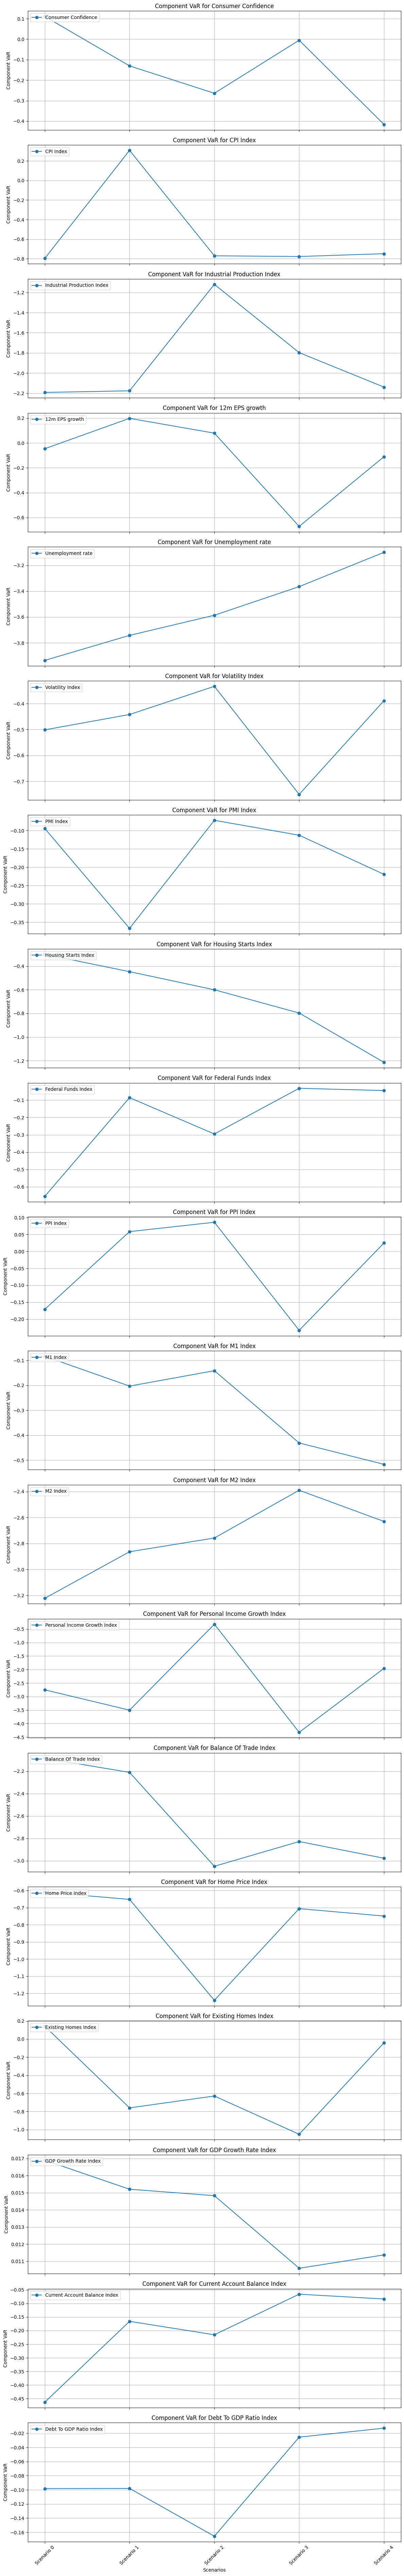

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_var_subplots(results, macro_columns):
    """
    Plot the distribution of Component VaR for each factor in separate subplots.

    Args:
        results (dict): Results from compute_var_for_scenarios, containing Total VaR and Component VaR.
        macro_columns (list): List of macro factor names.
    """
    # Initialize data
    scenarios = list(results.keys())  # Scenario names
    component_vars = [values['Component VaR'] for values in results.values()]  # Component VaR for each scenario
    component_vars = np.array(component_vars)  # Convert to numpy array

    # Number of factors
    n_factors = len(macro_columns)

    # Create subplots
    fig, axes = plt.subplots(n_factors, 1, figsize=(12, 4 * n_factors), sharex=True)

    for i, factor_name in enumerate(macro_columns):
        ax = axes[i]
        ax.plot(scenarios, component_vars[:, i], marker='o', label=factor_name)
        ax.set_title(f"Component VaR for {factor_name}")
        ax.set_ylabel("Component VaR")
        ax.legend(loc="upper left")
        ax.grid(True)

    # Add common x-axis label
    plt.xlabel("Scenarios")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_var_subplots(results, macros.columns[1:])

### (2)Constructing Tail Risk Hedges

1.Inner optimization: adjust weights among 5 assets.


In [ ]:
import numpy as np
from scipy.optimize import minimize

def optimize_asset_weights(asset_weights, initial_asset, lasso_weights, scenarios):
    """
    Optimize asset weights to minimize VaR exposure across macro factors.

    Args:
        asset_weights (np.ndarray): Initial asset weights (K-dimensional).
        lasso_weights (np.ndarray): LASSO coefficients (K x M matrix, where K is the number of assets and M is the number of macro factors).
        scenarios (np.ndarray): Scenarios matrix (M x N, where M is the number of macro factors and N is the number of scenarios).

    Returns:
        np.ndarray: Optimized asset weights.
    """
    # Number of assets
    K = asset_weights.shape[0]

    # Objective function: Minimize VaR exposure
    def objective(w):
        portfolio_exposure = np.mean(w.T @ lasso_weights @ scenarios.T)
        return (portfolio_exposure - initial_asset) ** 2  # L2-norm of exposures

    # Constraints: Weights sum to 1 and are non-negative
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # Sum of weights = 1
        {"type": "ineq", "fun": lambda w: w}  # Weights >= 0
    ]

    # Optimization bounds: Weights between 0 and 1
    bounds = [(0, 1) for _ in range(K)]

    # Run optimization
    result = minimize(objective, asset_weights, bounds=bounds, constraints=constraints)

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    return result.x



initial_asset = asset_weights @ Y_normalized[0]
# Optimize asset weights
optimized_weights = optimize_asset_weights(asset_weights, initial_asset, lasso_weights, scenarios)

# Print results
print("Optimized Asset Weights:", optimized_weights)


Optimized Asset Weights: [8.59649721e-17 1.38777878e-16 0.00000000e+00 1.00000000e+00
 2.56999112e-17]


2.Introducing more assets to reduce VaR under extreme conditions.